In [2]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

## Training data

In [125]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [126]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [127]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [132]:
test_no_bg = process_data.remove_background(scan_100206_long, mask_100206_long)

In [133]:
test_begin_0 = np.where(test_no_bg[:, 0] == 0)[0]

In [136]:
test_begin_0

array([ 46080,  52289,  58710,  61649,  65169,  75865,  77984,  82681,
        88184,  96165,  96248,  98616, 104386, 104471, 105834, 106935,
       112589, 112845, 112930, 115186, 115316, 121280, 121706, 124612,
       127409, 130165, 130591, 132693, 133084, 133597, 137541, 139400,
       139753, 141694, 141918, 142846, 148444, 148806, 149505, 149838,
       151134, 151227, 151272, 152002, 152206, 152349, 152407, 154601,
       156409, 158104, 158288, 158471, 159177, 159511, 160888, 160932,
       161452, 161721, 161983, 161984, 162113, 162132, 162210, 167928,
       168205, 168297, 169004, 169341, 171395, 171798, 171931, 171948,
       172006, 172027, 172164, 172422, 172512, 172608, 172704, 178028,
       178213, 179261, 181980, 182142, 182491, 182588, 182685, 188111,
       188564, 189253, 189586, 191392, 191682, 192585, 192681, 192778,
       198338, 199046, 199391, 199725, 201834, 202277, 202792, 205301,
       208912, 209605, 209942, 211902, 211903, 211904, 212326, 212401,
      

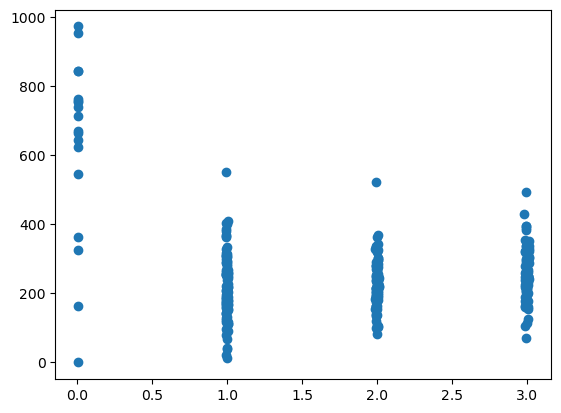

In [143]:
plt.plot(bvals_all, test_no_bg[930422,:], "o")

In [139]:
scan_100206_long[845451,:]

array([6704.40283203,  630.99127197,  211.24629211,  318.82394409,
        504.55914307,  386.30993652,  155.88322449,  526.62475586,
        516.15020752,  194.31488037,  611.7791748 ,  190.4210968 ,
        295.01586914,  593.07910156,  203.78581238,  384.11517334,
       6972.23583984,  425.44396973,  228.13539124,  277.37646484,
        345.67700195,  351.22134399,  300.18267822,  445.92837524,
        269.26135254,  308.71716309,  732.16296387,  377.91653442,
        229.0055542 ,  528.04382324,  261.96670532,  253.05070496,
       6568.37011719,  202.08164978,  553.2454834 ,  218.13262939,
        555.94897461,  278.75131226,  355.13546753,  266.76965332,
        206.87550354,  261.34887695,  244.15737915,  660.43737793,
        194.80184937,  469.1257019 ,  258.69174194,  293.92440796,
       7040.28076172,  547.21337891,  353.21115112,  339.99447632,
        260.35806274,  280.42892456,  289.72915649,  671.47375488,
        261.31918335,  388.38677979,  676.94488525,  295.99072

In [128]:
# Error voxels
indices_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [145]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indices_beginning_0_all] = 0

In [146]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [147]:
bvals = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [148]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals)

In [149]:
normalized_scan_100206 = scan_100206_long_no_background / S0_100206

In [175]:
len(np.where(S0_100206 < 100)[0])

609

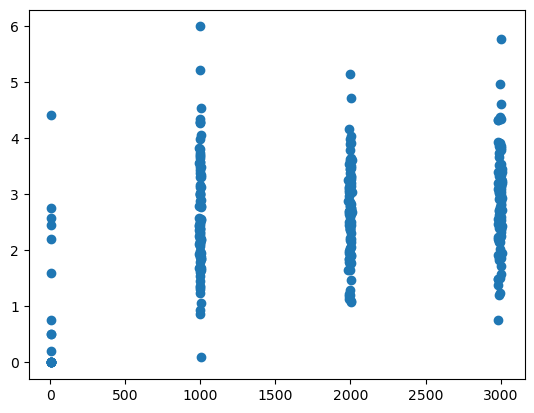

In [177]:
plt.plot(bvals_all*1e3, normalized_scan_100206[755852,:], "o")

In [9]:
bvals_all = np.loadtxt(config.data_folder2 + '/100206/bvals')* 1e-3
big_b_indices = np.where(bvals_all != 0.005)[0]

In [10]:
bvals = bvals_all[big_b_indices]

In [39]:
normalized_scan_100206_no_b5 = normalized_scan_100206[:, big_b_indices]

In [54]:
normalized_scan_100206_no_b5.shape

(935442, 270)

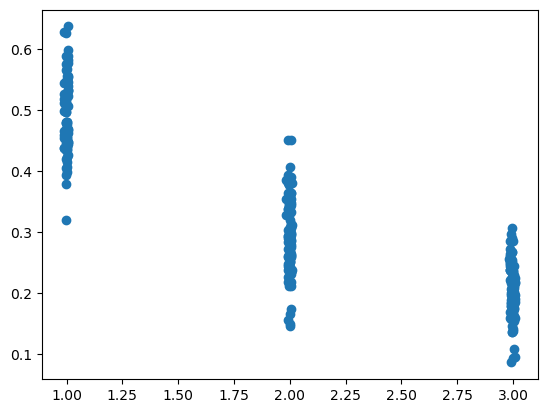

In [41]:
plt.plot(bvals, normalized_scan_100206_no_b5[1565,:], "o")

In [46]:
np.save("normalized_scan_100206_no_b5.npy",normalized_scan_100206_no_b5)

In [4]:
normalized_scan_100206_no_b5 = np.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/normalised_data/normalized_scan_100206_no_b5.npy")

## Neural Network

In [5]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [6]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [7]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [11]:
n_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n = n_all[:,big_b_indices].T
print(n.shape)

b_values = torch.FloatTensor(bvals)
gradient_directions = torch.FloatTensor(n)

net = BallStickNet(gradient_directions, b_values)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

(270, 3)


In [12]:
batch_size = 128
num_batches = len(normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [77]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.37it/s]


Loss: 1479.3701469153166
Average Loss: 0.20243160193148832
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.88it/s]


Loss: 1479.4394012987614
Average Loss: 0.20244107844810638
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.12it/s]


Loss: 1479.1728236228228
Average Loss: 0.20240460093361012
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.51it/s]


Loss: 1479.3806270509958
Average Loss: 0.20243303599493648
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.09it/s]


Loss: 1479.2930370271206
Average Loss: 0.20242105049632192
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.33it/s]


Loss: 1478.951212465763
Average Loss: 0.20237427647314765
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.82it/s]


Loss: 1479.4008232802153
Average Loss: 0.20243579957310007
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.31it/s]


Loss: 1479.2937576174736
Average Loss: 0.20242114909927114
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.55it/s]


Loss: 1479.3529149740934
Average Loss: 0.20242924397565593
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.80it/s]


Loss: 1479.4829694777727
Average Loss: 0.20244704015842538
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 4


  2%|█                                                         | 127/7308 [00:03<00:56, 126.33it/s]

X_batch: 
torch.Size([128, 270])
tensor([[0.4845, 0.1780, 0.3450,  ..., 0.4855, 0.2133, 0.1651],
        [0.1518, 0.1278, 0.0793,  ..., 0.1343, 0.0861, 0.0725],
        [0.6006, 0.1758, 0.1323,  ..., 0.5335, 0.4440, 0.2492],
        ...,
        [0.5557, 0.2974, 0.1902,  ..., 0.5992, 0.3727, 0.2436],
        [0.3601, 0.2737, 0.1779,  ..., 0.4541, 0.2234, 0.2016],
        [0.3674, 0.3195, 0.2746,  ..., 0.4055, 0.1652, 0.3635]])
X_pred: 
torch.Size([128, 270])
tensor([[9.8328e-01, 8.5307e-01, 1.5479e-04,  ..., 1.7046e-01, 9.7480e-01,
         7.4417e-01],
        [8.2420e-01, 4.2826e-01, 7.4408e-04,  ..., 1.9781e-01, 8.6219e-01,
         2.9018e-02],
        [8.7803e-01, 3.6482e-01, 7.8292e-04,  ..., 1.7142e-01, 9.3675e-01,
         1.9395e-02],
        ...,
        [3.2324e-01, 9.1421e-02, 1.2624e-01,  ..., 7.3997e-01, 3.9547e-01,
         1.1357e-02],
        [6.1294e-01, 9.9913e-03, 5.2408e-01,  ..., 7.8064e-01, 6.3200e-02,
         4.8256e-03],
        [7.6558e-01, 4.4312e-03, 9.1665

100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.88it/s]


Loss: 1479.5201971679926
Average Loss: 0.2024521342594407
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.13it/s]


Loss: 1479.419773235917
Average Loss: 0.2024383926157522
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 101.61it/s]


Loss: 1479.238392725587
Average Loss: 0.20241357316989422
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.65it/s]


Loss: 1479.4951770454645
Average Loss: 0.2024487105973542
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.15it/s]


Loss: 1120.0962125789374
Average Loss: 0.1532698703583658
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.22it/s]


Loss: 684.4786299495026
Average Loss: 0.0936615530855915
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.74it/s]


Loss: 519.6573848063126
Average Loss: 0.07110801653069412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.09it/s]


Loss: 528.3209749287926
Average Loss: 0.0722935105266547
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.17it/s]


Loss: 464.69179400336
Average Loss: 0.06358672605409961
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.45it/s]


Loss: 458.39867866644636
Average Loss: 0.06272559916070694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.45it/s]


Loss: 435.84327725786716
Average Loss: 0.05963920050052917
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.54it/s]


Loss: 442.88747129263356
Average Loss: 0.06060310225679168
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.21it/s]


Loss: 441.57568096369505
Average Loss: 0.060423601664435556
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.92it/s]


Loss: 434.5219256263226
Average Loss: 0.05945839157448312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.95it/s]


Loss: 444.14509327011183
Average Loss: 0.06077519064998794
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.87it/s]


Loss: 449.2874279941898
Average Loss: 0.06147884893188147
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.35it/s]


Loss: 441.42791194748133
Average Loss: 0.06040338149253986
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.94it/s]


Loss: 431.1795962092001
Average Loss: 0.05900103943749317
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.79it/s]


Loss: 421.87256750953384
Average Loss: 0.05772749965921371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.42it/s]


Loss: 423.29668000433594
Average Loss: 0.057922370006066766
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.50it/s]


Loss: 418.7682146974839
Average Loss: 0.05730271137075588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.41it/s]


Loss: 430.3945976844989
Average Loss: 0.05889362310953734
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.23it/s]


Loss: 422.34697234560736
Average Loss: 0.05779241548243122
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.88it/s]


Loss: 418.65774442837574
Average Loss: 0.05728759502303992
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.53it/s]


Loss: 421.51467926846817
Average Loss: 0.057678527540841296
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.97it/s]


Loss: 417.9711317527108
Average Loss: 0.05719364145494127
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.66it/s]


Loss: 419.05275199818425
Average Loss: 0.05734164641463933
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.24it/s]


Loss: 417.1189550056588
Average Loss: 0.05707703270466048
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.00it/s]


Loss: 416.0451442534104
Average Loss: 0.05693009636746174
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.93it/s]


Loss: 418.76654289267026
Average Loss: 0.057302482607097735
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.42it/s]


Loss: 416.78532552695833
Average Loss: 0.0570313800666336
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.78it/s]


Loss: 415.25618453347124
Average Loss: 0.056822138004032734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.34it/s]


Loss: 416.1671461244114
Average Loss: 0.05694679065741809
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.63it/s]


Loss: 414.72668027109466
Average Loss: 0.05674968257677814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.50it/s]


Loss: 428.1942882896401
Average Loss: 0.05859254081686373
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.29it/s]


Loss: 427.91888969554566
Average Loss: 0.05855485628017866
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.43it/s]


Loss: 437.69667772832327
Average Loss: 0.05989281304437921
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.66it/s]


Loss: 444.5573921171017
Average Loss: 0.06083160811673532
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.50it/s]


Loss: 441.5013936413452
Average Loss: 0.0604134364588595
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.17it/s]


Loss: 448.9772238098085
Average Loss: 0.06143640172548009
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 140.66it/s]


Loss: 471.7953989265952
Average Loss: 0.06455875737911812
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.20it/s]


Loss: 540.1603159196675
Average Loss: 0.07391356266005303
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 104.06it/s]


Loss: 564.6967617776245
Average Loss: 0.077271040199456
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.15it/s]

Loss: 486.7991226098966
Average Loss: 0.06661181207031973
Done, best loss: 414.72668027109466
Done


<All keys matched successfully>

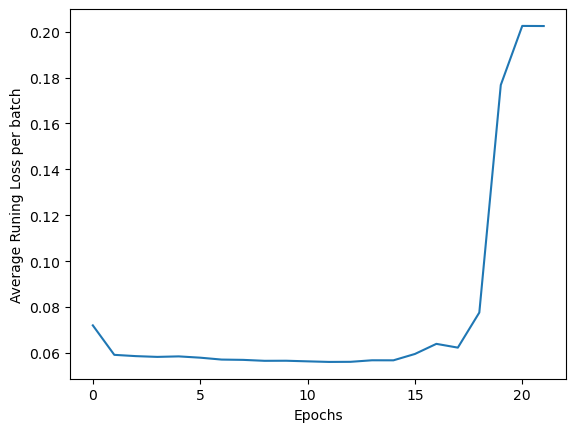

In [71]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

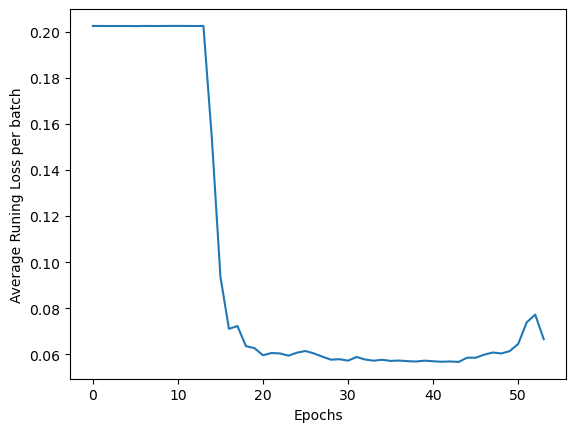

In [78]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [79]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=5, bias=True)
  )
)

In [ ]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train = net(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)))

In [83]:
lambda_iso_pred_train.shape

torch.Size([935442, 1])

ValueError: x and y must have same first dimension, but have shapes (288,) and (270,)

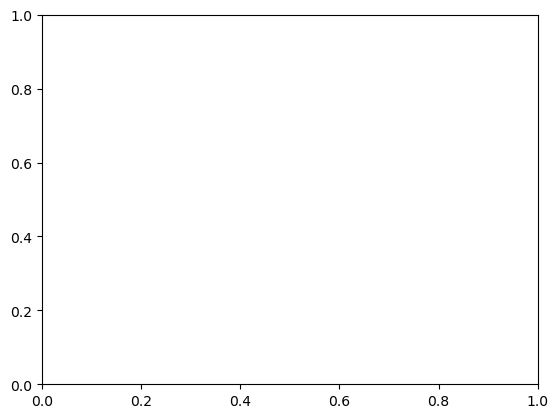

In [179]:
plt.plot(bvals*1e03, X_pred_train[0,:].detach().numpy(),  "o")
plt.plot(bvals*1e03,normalized_scan_100206_no_b5[0,:], ".")

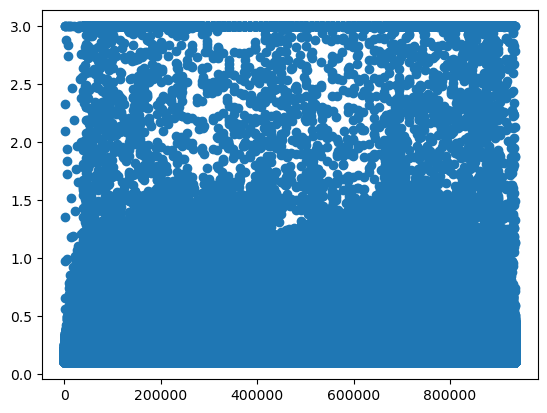

In [85]:
plt.plot(lambda_par_pred_train.detach().numpy(), 'o')

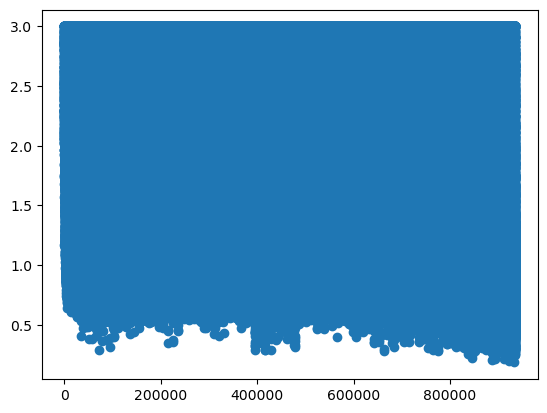

In [86]:
plt.plot(lambda_iso_pred_train.detach().numpy(), 'o')

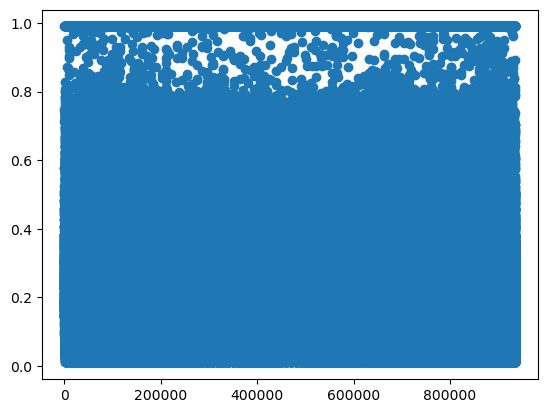

In [87]:
plt.plot(volume_0_pred_train.detach().numpy(), 'o')

In [92]:
def add_bg(mask_long, params):
    resume_params = np.copy(mask_long)
    no_bg_indices = np.where(mask_long == 1)[0]
    for i, index in enumerate(no_bg_indices):
        resume_params[index] = params[i]
    return resume_params

def back_to_3D(mask_long, parames_1d, shape):
    params_with_bg = add_bg(mask_long, parames_1d.detach().numpy())
    params_3d = np.reshape(params_with_bg, shape)
    return params_3d

In [93]:
lambda_par_pred_train_3d = back_to_3D(mask_100206_long_pro, lambda_par_pred_train, (145, 174, 145))

In [94]:
lambda_iso_pred_train_3d = back_to_3D(mask_100206_long_pro, lambda_iso_pred_train, (145, 174, 145))

In [95]:
volume_0_pred_train_3d = back_to_3D(mask_100206_long_pro, volume_0_pred_train, (145, 174, 145))

In [96]:
volume_1_pred_train_3d = back_to_3D(mask_100206_long_pro, volume_1_pred_train, (145, 174, 145))

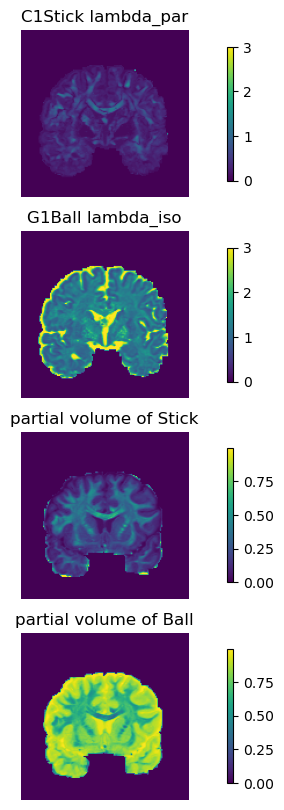

In [99]:
fig, axs = plt.subplots(4, 1, figsize=[10, 10])
axs = axs.ravel()

cf = axs[0].imshow(lambda_par_pred_train_3d[:,100,:].squeeze().T, origin='lower')
axs[0].set_title("C1Stick lambda_par")
axs[0].set_axis_off()
fig.colorbar(cf, ax=axs[0], shrink=0.8)

cf = axs[1].imshow(lambda_iso_pred_train_3d[:,100,:].squeeze().T, origin='lower')
axs[1].set_title("G1Ball lambda_iso")
axs[1].set_axis_off()
fig.colorbar(cf, ax=axs[1], shrink=0.8)

cf = axs[2].imshow(volume_0_pred_train_3d[:,110,:].squeeze().T, origin='lower')
axs[2].set_title("partial volume of Stick")
axs[2].set_axis_off()
fig.colorbar(cf, ax=axs[2], shrink=0.8)

cf = axs[3].imshow(volume_1_pred_train_3d[:,110,:].squeeze().T, origin='lower')
axs[3].set_title("partial volume of Ball")
axs[3].set_axis_off()
fig.colorbar(cf, ax=axs[3], shrink=0.8)

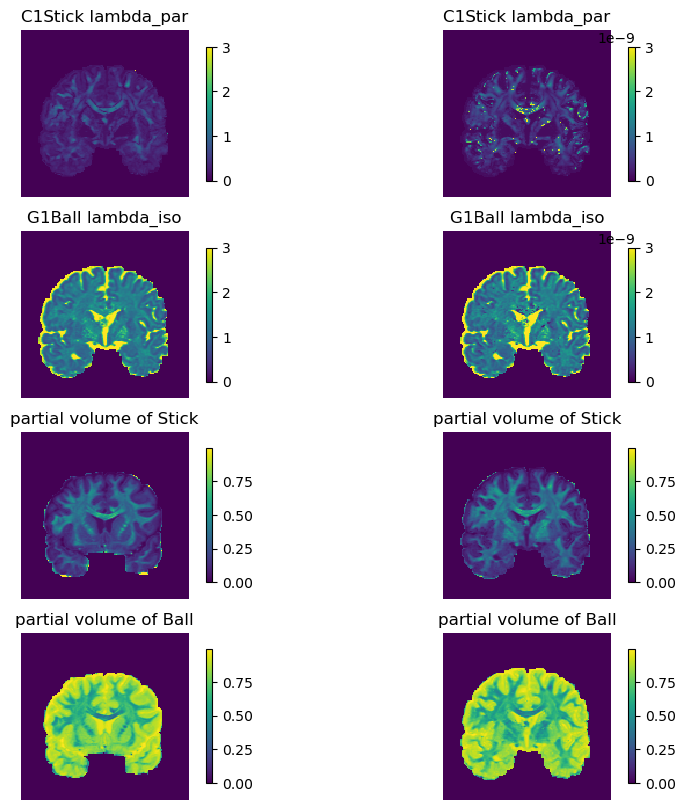

In [113]:
fig, axs = plt.subplots(4, 2, figsize=[10, 10])
axs = axs.ravel()

cf = axs[0].imshow(lambda_par_pred_train_3d[:,100,:].squeeze().T, origin='lower', interpolation='nearest')
axs[0].set_title("C1Stick lambda_par")
axs[0].set_axis_off()
fig.colorbar(cf, ax=axs[0], shrink=0.8)

cf = axs[1].imshow(fitted_parameters.get("C1Stick_1_lambda_par").squeeze().T, origin='lower', interpolation='nearest')
axs[1].set_title("C1Stick lambda_par")
axs[1].set_axis_off()
fig.colorbar(cf, ax=axs[1], shrink=0.8)

cf = axs[2].imshow(lambda_iso_pred_train_3d[:,100,:].squeeze().T, origin='lower', interpolation='nearest')
axs[2].set_title("G1Ball lambda_iso")
axs[2].set_axis_off()
fig.colorbar(cf, ax=axs[2], shrink=0.8)

cf = axs[3].imshow(fitted_parameters.get("G1Ball_1_lambda_iso").squeeze().T, origin='lower', interpolation='nearest')
axs[3].set_title("G1Ball lambda_iso")
axs[3].set_axis_off()
fig.colorbar(cf, ax=axs[3], shrink=0.8)

cf = axs[4].imshow(volume_0_pred_train_3d[:,110,:].squeeze().T, origin='lower', interpolation='nearest')
axs[4].set_title("partial volume of Stick")
axs[4].set_axis_off()
fig.colorbar(cf, ax=axs[4], shrink=0.8)
cf = axs[5].imshow(fitted_parameters.get("partial_volume_0").squeeze().T, origin='lower', interpolation='nearest')
axs[5].set_title("partial volume of Stick")
axs[5].set_axis_off()
fig.colorbar(cf, ax=axs[5], shrink=0.8)

cf = axs[6].imshow(volume_1_pred_train_3d[:,110,:].squeeze().T, origin='lower', interpolation='nearest')
axs[6].set_title("partial volume of Ball")
axs[6].set_axis_off()
fig.colorbar(cf, ax=axs[6], shrink=0.8)
cf = axs[7].imshow(fitted_parameters.get("partial_volume_1").squeeze().T, origin='lower', interpolation='nearest')
axs[7].set_title("partial volume of Ball")
axs[7].set_axis_off()
fig.colorbar(cf, ax=axs[7], shrink=0.8)

In [100]:
scan_100206_slice = scan_100206[:, 100, :, :]

In [101]:
def get_acquisition_scheme(bvals, gradient_directions):
    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

In [102]:
scheme_hcp_100206_slice = get_acquisition_scheme(bvals_all*1e9, n_all.T)

In [103]:
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
BAS_mod = MultiCompartmentModel(models=[stick, ball])

We highly recommend installing numba for faster function execution and model fitting.
We highly recommend installing pathos to take advantage of multicore processing.


In [104]:
BAS_fit_hcp_100206_slice = BAS_mod.fit(scheme_hcp_100206_slice, scan_100206_slice, mask_100206[:,100,:])

Setup brute2fine optimizer in 0.20186400413513184 seconds
Fitting of 8433 voxels complete in 165.811292886734 seconds.
Average of 0.01966219529073094 seconds per voxel.


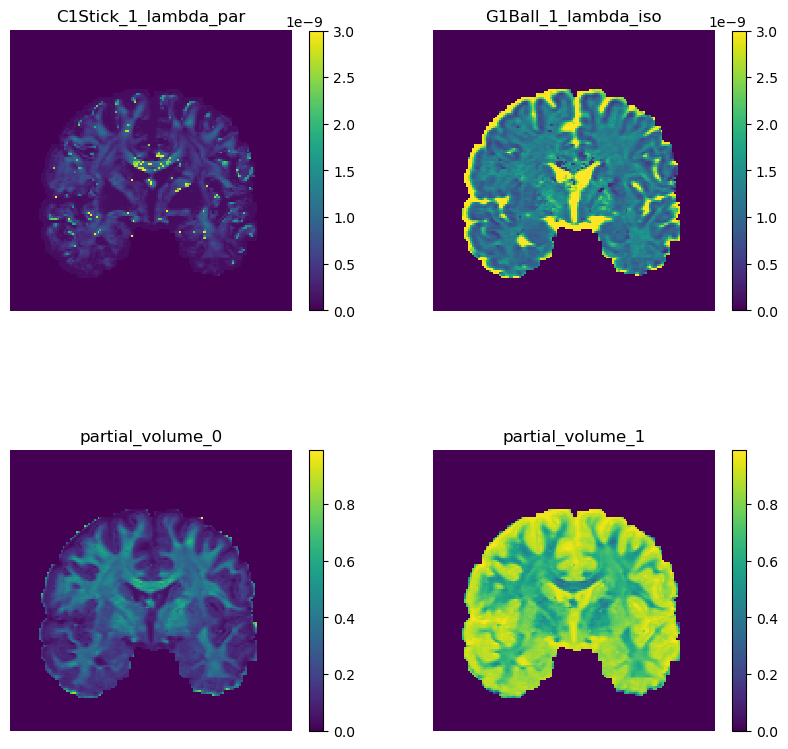

In [105]:
fitted_parameters = BAS_fit_hcp_100206_slice.fitted_parameters

fig, axs = plt.subplots(2, 2, figsize=[10, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin='lower', interpolation='nearest')
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.8)
    counter += 1

In [111]:
fitted_parameters.keys()

dict_keys(['C1Stick_1_mu', 'C1Stick_1_lambda_par', 'G1Ball_1_lambda_iso', 'partial_volume_0', 'partial_volume_1'])